In [2]:
!pip install --quiet -U langgraph langchain_ollama langchain_core

**States** are the first things defined about the graph. These consist of the schema of the graph, and reducer functions to specify how to apply state updates.

In [3]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

**Nodes** are python functions (synchronous or asynchronous). The first positional argument is the state.

In [4]:
def node_1(state):
    print("---Node 1---")
    return {"graph state": state['graph_state'] + " I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph state": state['graph_state'] + " happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph state": state['graph_state'] + " sad!"}

**Schemas** are typically constructed in `TypedDict` types. `Pydantic` base models can also be used.

In [7]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(InputState, OutputState):
    pass

def answer_node(state: InputState):
    return {"answer": "bye", "question": state["question"]}

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node(answer_node)
builder.add_edge(START, "answer_node")
builder.add_edge("answer_node", END)
graph = builder.compile()

print(graph.invoke({"question": "hi"}))

{'answer': 'bye'}


**Edges** connect each node. Normal edges are used if you want to always go from like `node_1` to `node_2`.
**Conditional edges** are used if you want optional routes between various nodes.
 ```python
graph.add_conditional_edges("node_1", routing_function)
```
The Routing function accepts current states of the graph, and returns a value. The default return value is used as the name of node or list of nodes to send the state to the next. Similar to functional programming chains.

You can also provide a dictionary of optional routes.
```python
graph.add_conditional_edges("node_a", routing_function, {True: "node_b", False: "node_c"})
```

In [5]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    user_input = state['graph_state']
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

Once components have been defined above, they can be added to a graph. Start with a **StateGraph** class.

The **StateGraph** class is the main graph class at this point. It's parameterized by a user defined `State` object.

Initialize a StateGraph with `State` class as defined above:
```python
class State(TypedDict):
    graph_state: str
```

We use START nodes, that sends user input to the graph, to indicate where to start on the graph.
The **START** node is a special node that represents the node that sends user input ot the graph, and the main purpose for referencing this node is to determine which nodes should be called first.

```python
from langgraph.graph import START
graph.add_edge(START, "node_a")
```
The `END` node is a special node that represents a terminal node, and is referenced when you want to denote which edges have no actions after they are complete.

```python
from langgraph.graph import END

graph.add_edge("node_a", END)
```

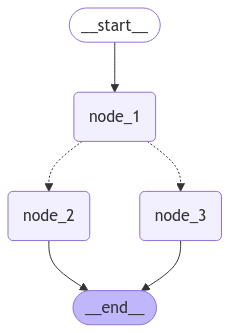

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"graph_state": "Hi, this is Adam."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Adam.'}

In [8]:
result = await graph.ainvoke({"graph_state": "Hello there!"})

---Node 1---
---Node 2---


# Tools
**Tools** are utilities designed to be called by a model: their inputs are designed to be generated by models, and their outputs are designed to be passed back to models. Tools are needed whenever you want a model to control parts of your code or call out to external APIs.

A **tool** consists of:
1. The `name` of the tool.
2. A `description` of what the tool does.
3. A `JSON schema` defining the inputs of the tool.
4. A `function` (and, optionally, an async variant of the function).

When a **tool** is bound to a model, the name, description, and JSON schema are provided as context to the model.

Given a list of tools and a set of instructions, a model can request to call one ore more tools with specific inputs.

```python
tools = [...]
llm_with_tools = llm.bind_tools(tools)
ai_msg = llm_with_tools.invoke("do xyz...")
```

The `AIMessage` returned from the model **MAY** have `tool_calls` associated with it.

Tool calling allows a chat model to respond to a given prompt by generating output that matches a user-defined schema.

```python
AIMessage(
    tool_calls=[{
        name: "get_weather",
        args: {
            location: "Hawaii",
        },
    }]
)
```

HumanMessage, AIMessage, SystemMessage, and ToolMessage.

Let's run through each type of message.

In [9]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Adam"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Adam"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Adam

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Adam

I want to learn about the best place to see Orcas in the US.


In [10]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model="deepseek-r1:7b")
result = llm.invoke(messages)
type(result)

result

AIMessage(content='<think>\nAlright, so I want to figure out the best places in the US to see Orcas. I remember that Orcas are these large whales, right? They\'re sometimes called orcas or killer whales. I think they live in the Pacific Ocean, which is pretty far west from where most people are. So, since the US spans a lot of ocean regions, including Alaska and the West Coast, maybe those areas have higher chances of seeing Orcas.\n\nI also recall that some places are more popular than others for tourists. Maybe there\'s a specific region known as the "oarfish hotspot" in Alaska? I think I\'ve heard that name before. Places like Juneau or Homer might be part of this area. I should probably look into those locations because they seem to be popular among tourists looking to see Orcas.\n\nNow, how do people actually go about seeing these creatures? I guess boat tours are a common method. Tour companies likely have expertise in tracking and spotting Orcas. Places that offer guided tours m

In [11]:
result.response_metadata

{'model': 'deepseek-r1:7b',
 'created_at': '2025-02-25T01:27:44.311352Z',
 'done': True,
 'done_reason': 'stop',
 'total_duration': 33614382250,
 'load_duration': 574949208,
 'prompt_eval_count': 49,
 'prompt_eval_duration': 5037000000,
 'eval_count': 1219,
 'eval_duration': 27775000000,
 'message': Message(role='assistant', content='', images=None, tool_calls=None)}

When a model has to interact with external systems you have to use **tools**.

In [12]:
def multiply(a: int, b: int) -> int:
    return a * b

llm_with_tools = llm.bind_tools([multiply])

tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multipled by 3", name="Adam")])

ResponseError: registry.ollama.ai/library/deepseek-r1:7b does not support tools (status code: 400)

In [13]:
tool_call.tool_calls

NameError: name 'tool_call' is not defined

In [14]:
import os
from langchain_openai import ChatOpenAI
os.environ["OPENAI_API_KEY"] = os.environ.get("OPEN_AI_KEY")

llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [15]:
result

AIMessage(content="The San Juan Islands in Washington State are one of the best places in the United States to see orcas in the wild. Situated in the Pacific Northwest, this area is known for its resident pods of orcas, particularly during the summer months. The waters around the islands provide a rich environment for orcas, with abundant salmon and other marine life.\n\nAnother excellent spot is the southern coast of Alaska, especially around the Kenai Fjords and Prince William Sound. Orcas are frequently seen in this area, including both resident and transient pods.\n\nBoth regions offer boat tours and whale-watching excursions, giving visitors a chance to observe these magnificent creatures in their natural habitat. Timing and weather can influence visibility, so it's a good idea to plan your trip during peak viewing seasons and consult local tour operators for the best experience.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 164, 'p

In [16]:
llm_with_tools = llm.bind_tools([multiply])
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Adam")])

In [17]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_p5tQe0rJCrbi8hYM7CjNHe3B',
  'type': 'tool_call'}]

In [18]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers
**Reducers** are key to understanding how updates from nodes are applied to the `State`. Each key in the `State` has its own independent reducer function. If no reducer function is explicitly specified then it is assumed that all updates to that key should override it.

Each node will return a new value for our state key `messages`.

But this new value will override the prior `messages` value.

As our graph runs, we want to append messages to our messages state key.

In [19]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [21]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"), HumanMessage(content="I'm looking for information on marine biology.", name="Adam")]

new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_messages, new_message)


[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='7081e2be-c4cd-4480-8a95-eb12646cb603'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Adam', id='5fcfc5c6-17d8-43a1-afd1-ca54cface952'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='ff7ab77e-6e97-4fe9-a000-9b8e39385539')]

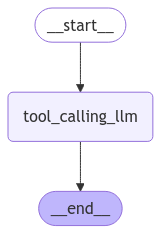

In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!", name="Adam")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Adam

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


In [25]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_b11GlXxlXkipWV20Sk6hmyzi)
 Call ID: call_b11GlXxlXkipWV20Sk6hmyzi
  Args:
    a: 2
    b: 3
